# Lithium Ion Battery Example

## Single particle model of a battery anode
 
In this example we will illustrate how to calculate electric potential of a battery half-cell (focused on just one electrode--the anode), during charging of the battery.

Note that the thermodynamic model for the `BinarySolutionTabulatedThermo` class, used to descrige the intercalation of graphite, is presented in greater detail in the reference: M. Mayur, S. DeCaluwe, B. L. Kee, W. G. Bessler, "Modeling thermodynamics and kinetics of intercalation phases for lithium-ion batteries in open source software", _Electrochimica Acta_, *323*, 2019, p. 134797.

Other than the typical Cantera dependencies, plotting functions require that you have matplotlib installed, and integration requires Scipy's solve_ivp. See https://matplotlib.org/ and https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html for additional info.

The battery here, can be thought of as consisting of two particles--anode and cathode--connected by a liquid electrolyte:

<img src="SingleParticleBattery.png" alt="Cartoon of a Single Particle Battery Model" style="width: 500px;"/>

For simplicity's sake, we will focus on just the anode particle and the adjacent electrolyte.  The state of the anode will be characterized by that of a representative/average anode particle. 

### State variables
The state of our system is presented by the following variables:

- $\phi_{\rm anode}$: electric potential of graphite anode.
- $\phi_{\rm elyte}$: electric potential of electrolyte.
- $X_{k,\,{\rm anode}}$: Mole fraction of intercalated Li in the anode.
- $C_{k,\,{\rm elyte}}$: molar density of electrolyte species $k,\,{\rm elyte}$.

### Processes:
There are four processes occuring in our simulation domain, each associated with the movement of electrical charge and a corresponding current $I$:
- External applied current $i_{\rm ext}$
- Ionic current $i_{\rm io}$ which brings Li$^+$ ions in the electrolyte phase into/out of the domain.
- Electro-chemical reactions at the anode-electrolyte interface, with an associated Faradaic current $i_{\rm Far}$.
- Double-layer current $i_{\rm dl}$, associated with the movement of charge between the bulk of a phase and the phase interface.

Each of these processes impacts our state variables, in some way.


<img src="spm_interfaces.png" alt="Cartoon of anode processes." style="width: 500px;"/>

Note from the image that all current densities $i$ are defined as positive when they move positive charge toward the anode current collector. This will be important, below, when we define our residual function.

### Assumptions
The primary two assumptions that we will make are:
- The battery is isothermal (constant temperature).
- The bulk interior of any phase is charge neutral.

The first assumption is straightforward enough, but the second requries a little explanation.  In electrochemical systems, charge buildup can occur at the interfaces between charges, but the interior of each phase is very nearly charge neutral, at all times.  If a charge imabalance occurs in the interior of a phase, it typically results in very large electric fields, which drive the charge toward neutrality.  Simply assuming charge neutrality, then, is a decent approximation. 

This has three main impacts on our simulation:

1. If the domain as a whole is charge neutral, that means that the external applied current $i_{\rm ext}$ at any time is exactly equal to the ionic current $i_{\rm io}$ entering the anode domain.
2. At any given time, the faradaic current $i_{\rm Far}$ is determined by the local state variables $\phi_{\rm anode}$, $\phi_{\rm elyte}$, $X_{k,\,{\rm anode}}$, and $C_{k,\,{\rm elyte}}$.  So there is no guarantee that $i_{\rm Far} = i_{\rm ion} = i_{\rm elyte}$, which is required to maintain charge neutrality in the individual phases.  The double layer current, $i_{\rm dl}$, then, is calculated at any given time as that required to maintain charge neutrality in the phases.  There is an equal and opposite movement of charges to the interface on either side of the phase bondary:

In the anode phase:
$$ i_{\rm dl} = i_{\rm Far} - i_{\rm ext}$$
or in the electrolyte phase:
$$ i_{\rm dl} = i_{\rm Far} - i_{\rm io}$$

3. From this, we know that the movement of Li$^+$ ions out of the bulk electrolyte to the anode or the interface, $i_{\rm Far} + i_{\rm dl}$ is equal to the movement of Li$^+$ ions into the anode, $i_{\rm io}$.  Therefore, the electrolyte species concentrations are constant, in this relatively simple model, and can be stored as a parameter rather than a state variable.

### Boundary conditions:
The primary boundary condition will be the applied current $i_{\rm ext}$--this is the current at which the user charges the battery.

While not technically a boundary condition, we will also assume that the electrolyte electric potential equals zero. We only care about the electric potentials in a _relative_ sense, and as such can set one of $\phi_{\rm anode}$ and $\phi_{\rm elyte,\, anode}$ to the reference potential of zero (because it is the difference in electric potential which drives currents, the actual potential values are irrelevant). 

Note that the cathode potential will also be relative to the electrolyte potential, and so our cell voltage, were we simulating the entire cell:

$$V_{\rm cell} = \left(\phi_{\rm cathode} - \phi_{\rm elyte}\right) -  \left(\phi_{\rm anode} - \phi_{\rm elyte}\right) =  \phi_{\rm cathode} - \phi_{\rm anode}$$
is unaffected by our choice of a reference potential.

## Begin by importing the necessary packages:

In [1]:
import cantera as ct
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

### Build the model

We're actually going to build the model "backwards" - jump down to the bottom to build the model framework, and then work back from there to fill in the necessary model components. 

The blocks are all numbered in order, the numbers just run in reverse so head to the bottom and look for item 1!

### 4. Provide user inputs

Given the subsequent cells, we need to provide the external current, strings to represent the input/mechanism file names, the microstructure of the anode (volume fraction, anode average particle diameter, and thickness0, double-layer capacitance, and initial conditions:

In [33]:
class inputs:
    i_ext = 0.001 #A/cm2
    
    mech = "lithium_ion_battery.yaml"
    anode_name = "anode"
    conductor_name = "electron"
    elyte_name = "electrolyte"
    int_name = "edge_anode_electrolyte"

    eps_anode = 0.55
    d_part_anode = 500-9
    
    dy = 50e-6 # m
    
    C_dl_anode = 300e-3 # F/m2 of interface
    
    X_Li_init = 1e-2 # [-] Initial mole fraction of LiC6 in anode
    phi_init = -2.5  # [V] Initial anode electric potential, relative to the electrolyte.

### 3. Create class structures for params, anode, and electrolyte.

We will create Python class objects to hold all necessary parameters associated with the simulation, plus parameters and Cantera objects associated with the anode and electrolyte phases.

The electrolyte phase properties are constant, so we set there once, here, and do not need to pass the object to any functions. The anode class contains Cantera objects for the anode phase, the electron-conducting phase (which in reality is the same as the anode phase, but Cantera currently currently considers an electron as equivalent to other chemical species in the phase.  It is therefore easier to consider a separate "conductor" phase whose only species is the electron.

The anode class also stores the double layer capacitanbce and the molar density of the discharged anode (kmol of Li 'host' sites per total volume of electrode).

The params class holds other parameters, including the external current density, integration time spane, anode phase volume fraction, anode thickness, and anode/electrolyte interface area (m$^2$ interface per m$^2$ geometric area).

In [28]:
elyte = ct.Solution(inputs.mech, inputs.elyte_name)
elyte.electric_potential = 0.0

class anode:
    obj = ct.Solution(inputs.mech, inputs.anode_name)
    conductor = ct.Solution(inputs.mech, inputs.conductor_name)
    
    interface = ct.Interface(inputs.mech, inputs.int_name, [obj, conductor, elyte])
    
    C_dl = inputs.C_dl_anode
    
    molar_density = obj.density_mole*inputs.eps_anode
    
    i_Li = obj.species_index("Li[anode]")
    

# We don't need to store this, but calculating is separately makes subequent 
#   calcualtions simpler:
capacity = anode.obj.density_mole*inputs.eps_anode*inputs.dy*ct.faraday #A-s/m2

class params:
    i_ext = 10000*inputs.i_ext # convert to A/m2
    
    t_span = capacity/i_ext
    
    eps_anode = inputs.eps_anode
    dy = inputs.dy
    
    # Assume spherical particles with no overlap:
    A_int = eps_anode*6*dy/inputs.d_part_anode

### 2. The residual function

We need one governing equatio for each state variable.  We have already assumed $phi_{\rm elyte} = 0.0$ V, so that leaves governing equations for:
- $\phi_{\rm anode}$: electric potential of graphite anode.
- $X_{k,\,{\rm anode}}$: Mole fraction of intercalated Li in the anode.
- $C_{k,\,{\rm elyte}}$: molar density of electrolyte species $k,\,{\rm elyte}$.

#### Anode electric potential:
Assuming that the bulk phase potential on either side of the anode-electrolyte interface is equilibrated with the double layer potential, the anode potential is defined by the equation for the double layer potential:

$$ \Delta \phi_{\rm dl} = \phi_{\rm anode} - \phi_{\rm elyte}$$

which leads to 

$$ \phi_{\rm anode} = \Delta \phi_{\rm dl} + \phi_{\rm elyte}$$

Finally, given our assumption that $\phi_{\rm elyte} = 0$:

$$ \phi_{\rm anode} = \Delta \phi_{\rm dl}$$

We model the double layer as a capacitor, so that the voltage is equal to the charge stored in the double layer, divided by a constant capacitance:

$$\frac{d\phi_{\rm anode}}{dt} = \frac{d\Delta\phi_{\rm dl}}{dt} = \frac{1}{C_{\rm dl}}\frac{dQ_{\rm dl}}{dt}$$

Lastly, recognizing that $\frac{dQ_{\rm dl}}{dt} = -i_{\rm dl}$ (positive $i_{\rm dl}$ means the anode side of the dl becomes more negative), we get: 
<div class="alert-danger">
$$\frac{d\phi_{\rm anode}}{dt} = -\frac{i_{\rm dl}}{A_{\rm int}C_{\rm dl}}$$
</div>
where $I_{\rm dl}$ is defined as above and $A_{\rm int}$ is equal to the anode-electrolyte interface area, per unit geometric area of the battery.  We will show calculation of $i_{\rm dl}$ further below.

#### Mole fraction of intercalated Li in the anode phase
We track this via $X_{\rm LiC_6}$, where the anode is assumed to consist of either $C_6$ or $LiC_6$ (with the mole fractions summing to one).

From a mole balance, we have:
<div class="alert-danger">
$$\frac{dX_{\rm LiC_6}}{dt} = \frac{A_{\rm int}}{n_{\rm anode}\varepsilon_{\rm anode}\Delta y_{\rm anode}} \dot{s}_{\rm LiC_6}$$
</div>

where $n_{\rm anode}$ is the molar density of ${\rm C_6}$ in the discharged anode (kmol/m$^3$ of graphite), $\varepsilon_{\rm anode}$ is the volume fraction of graphite in the anode, $\Delta y_{\rm anode}$ is the anode thickness, and $\dot{s}_{\rm LiC_6}$ is the molar production rate of LiC$_6$ due to interfacial reactions (kmol of Li per m$^2$ of interface area per second).  This last term is calculated via Cantera, via the function `int.get_net_prod_rates(anode)`, which retrieves the anode-phase production rates due to reactions associated with the interface object `int`.  

We can use a similar approach to get the faradaic current, via the production of electrons in the conductor phase. We noted before that positive #i_{\rm Far}$ corresponds to positive charge moving to the anode.  Thefore, it is proportional to the opposite of the electron creation rate:

$$i_{\rm Far} = -\frac{A_{\rm int}}{\Delta y_{\rm anode}}\dot{s}_{\rm e^-} $$

In [29]:
def residual(t, SV, params, anode):
    # The _ character above is a placeholder for the simulation time. 
    #   Because the derivative depends only on the state variables and 
    #   not directly on time, the `t` variable is unused.  The _ lets us
    #   avoid allocating any memory for the variable.
    # Set the state of the anode and anode conductor object:
    anode.obj.X = f"Li[anode]:{SV[1]}, V[anode]:{1-SV[1]}"
    anode.obj.electric_potential = SV[0]
    anode.conductor.electric_potential = SV[0]
    
    # Li production rate is opposite that of the electron
    i_Far = -(ct.faraday*params.A_int
             *anode.interface.get_net_production_rates(anode.conductor))
    i_dl = params.i_ext - i_Far  
    sdot_Li_anode = anode.interface.get_net_production_rates(anode.obj)[anode.i_Li]
    
    # Initialize the derivative:
    dSVdt = np.zeros_like(SV)
    
    # First variable is the anode potential:
    dSVdt[0] = -i_dl/params.A_int/anode.C_dl
    
    # Second variable is the degree of lithiation:
    dSVdt[1] = params.A_int*sdot_Li_anode/anode.molar_density/params.dy
    
    return dSVdt
    

## 1. The main code - Initialize the model, run the integrator, and plot results!

We will use the `scipy.integrate` function `solve_ivp`, which takes an initial state and integrates it over a user-defined time span, according to user-defined differential equations for each variable.

At a minimum, then, the integrator function requires three things (in the following order):
- The derivative function (which we will generalize to call the "residual," here).
- The time span over which to integrate
- The initial values of all state variables

Each of these must be predefined--scroll up to block 2, which defines the residual function.  We will also pass in extra arguments to the function via `args`, which includes the user defined parameters plus the anode and electrolyte class objects.

We will save the results (the time for each time step and the state vector SV at each time step) to a variable called `solution`.

Then we will do some basic plotting of the results.  Note that the plotting expects that the anode potential (relative to that the electrolyte) is stored as the first variable, and the degree of lithiation (mole fraction of LiC6 in the anode) is stored as the second variable.  Note also that the code below expects that the params object has varaibles `tspan` and `i_ext`.


<IPython.core.display.Javascript object>


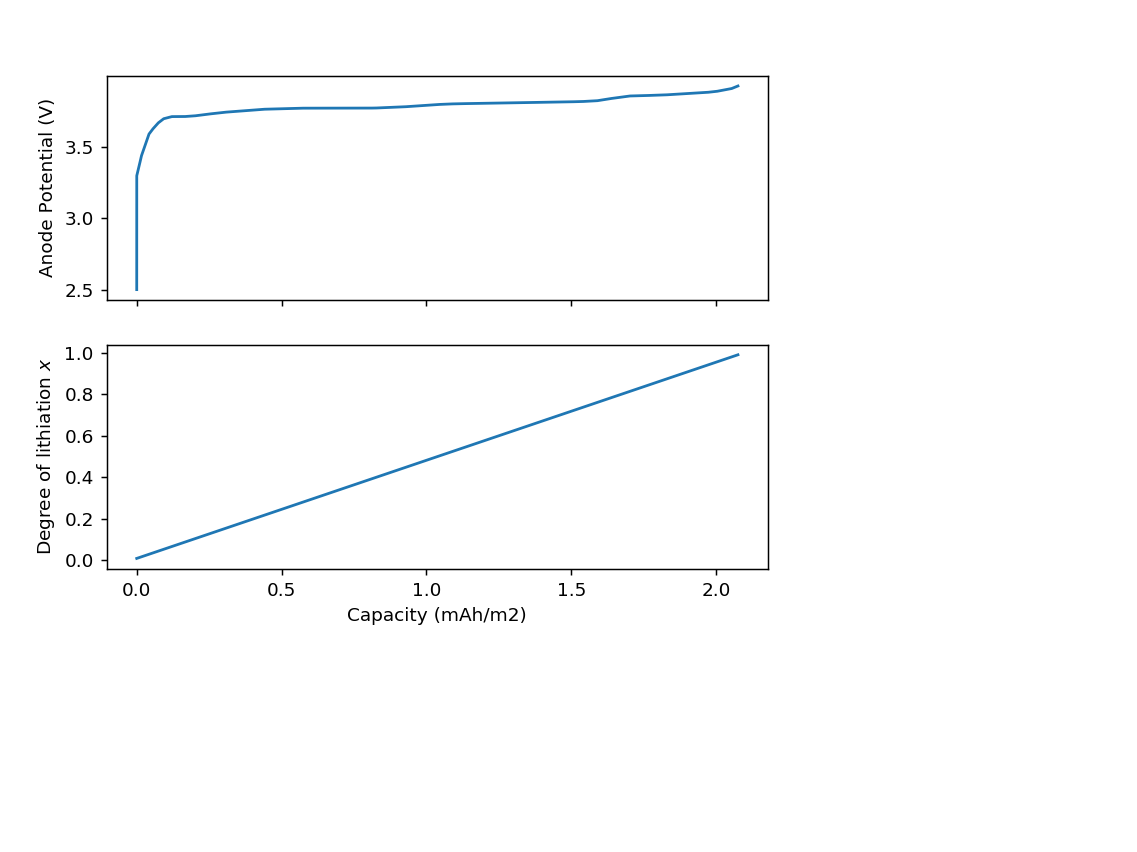

[Text(0, 0.5, 'Degree of lithiation $x$'), Text(0.5, 0, 'Capacity (mAh/m2)')]

In [30]:
# This helps make the plotting look nice :)
%matplotlib notebook

# Initial solution vector at t = 0;
SV_0 = np.array([inputs.phi_init, inputs.X_Li_init])

# Integrate over the charging process.  Note that we don't want to go all the way to 100% 
#  charged, as the potential goes to infinity, at this condition.
# The 'BDF' method is good for stiff systems, and speeds the integration considerably.
solution =  solve_ivp(residual, [0, 0.98*params.t_span], SV_0, args=(params,anode), 
                      method='BDF')

# Plot the half-cell potential and anode degree of lithiation as a 
#   function of the stored capacity:
fig, axs = plt.subplots(2,1, sharex=True)

# Convert time to stored capacity:
Capacity = 0.1*solution.t*params.i_ext/3600 #mAh/cm

# Plot Cell Potential vs. Capacity.
#   Recall that we stored this in locatin '0' (the first variable):
axs[0].plot(Capacity, -solution.y[0])
axs[0].set(ylabel='Anode Potential (V)')
    
# Plot anode degree of lithiation vs. Capacity.
#   Recall that we stored this in location '1' (the 2nd variable):
axs[1].plot(Capacity, solution.y[1])
axs[1].set(xlabel='Capacity (mAh/m2)', ylabel='Degree of lithiation $x$')
            

### We can also model the discharge of the anode.

To do so, we simply need to take the final solution vector as our new `SV_0`, and change the sign on the external current:

In [31]:
# Discharge current is opposite of the charge current:
params.i_ext = -10000*inputs.i_ext 
# Store the end of the charge process as the initial state for discharge:
SV_0 = solution.y[:,-1]


#### Now integrate and plot, just like before:

<IPython.core.display.Javascript object>


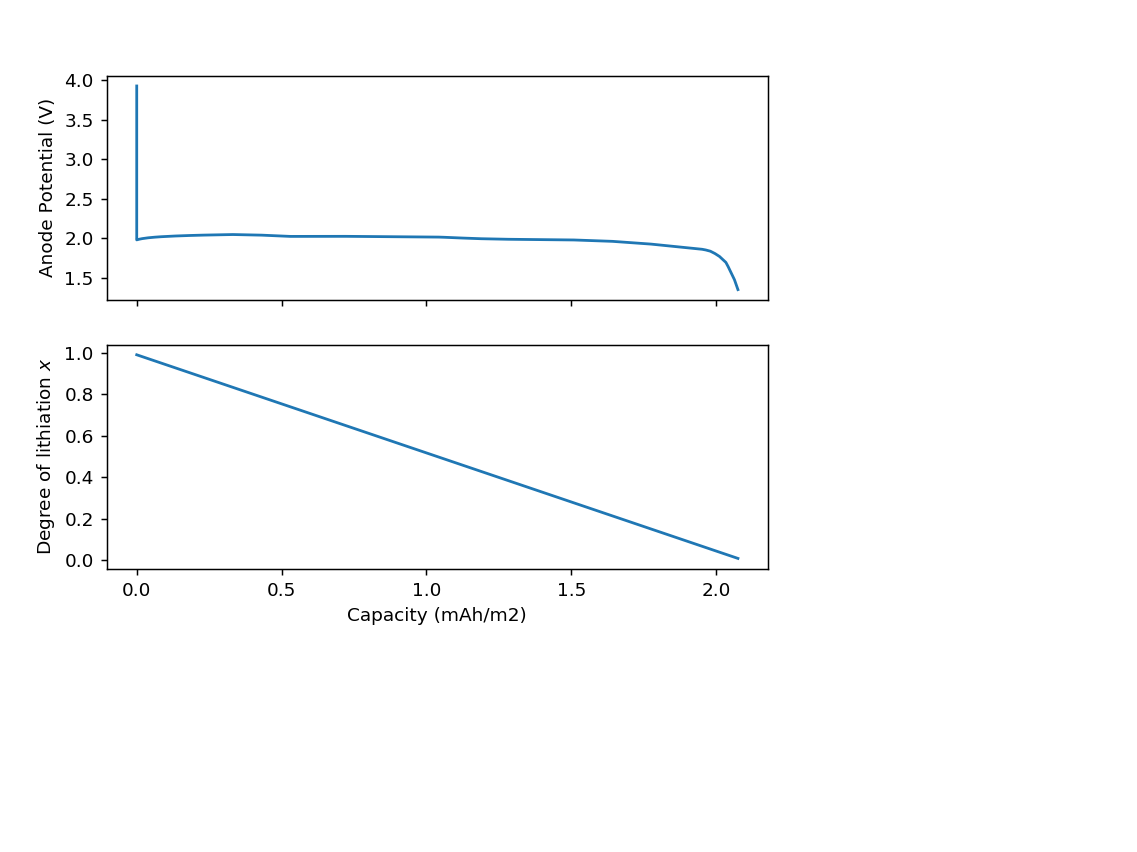

[Text(0, 0.5, 'Degree of lithiation $x$'), Text(0.5, 0, 'Capacity (mAh/m2)')]

In [32]:
# Now integrate:
solution =  solve_ivp(residual, [0, 0.98*params.t_span], SV_0, args=(params, anode), 
                      method='BDF')

# Plotting results, just like before:
fig, axs = plt.subplots(2,1, sharex=True)

Capacity = abs(0.1*solution.t*params.i_ext/3600) #mAh/cm

# Plot Cell Potential vs. Capacity.
#   Recall that we stored this in locatin '0' (the first variable):
axs[0].plot(Capacity, -solution.y[0])
axs[0].set(ylabel='Anode Potential (V)')
    
# Plot anode degree of lithiation vs. Capacity.
#   Recall that we stored this in location '1' (the 2nd variable):
axs[1].plot(Capacity, solution.y[1])
axs[1].set(xlabel='Capacity (mAh/m2)', ylabel='Degree of lithiation $x$')